# Forward modelling gravity data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import discretize
import simpeg
from simpeg import potential_fields

## Build synthetic mesh

In [2]:
hx = [(50.0, 256)]
hz = [(25.0, 256)]
mesh = discretize.TreeMesh(h=[hx, hx, hz], origin="CCN")
mesh.refine_box(x0s=(-3e3, -3e3, -3e3), x1s=(3e3, 3e3, 0), levels=3, finalize=False)
mesh.refine_box(x0s=(-2e3, -2e3, -2e3), x1s=(2e3, 2e3, 0), levels=6, finalize=False)
mesh.finalize()
mesh

OcTreeMesh: 0.09% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  2   :       28             ---------------------------   --------------------
  3   :       176         x:    -6400.0   ,   6400.0         200.0   ,   3200.0  
  4   :       536         y:    -6400.0   ,   6400.0         200.0   ,   3200.0  
  5   :      1296         z:    -6400.0   ,     0.0          100.0   ,   1600.0  
  6   :      12672     
-----------------------
Total :      14708

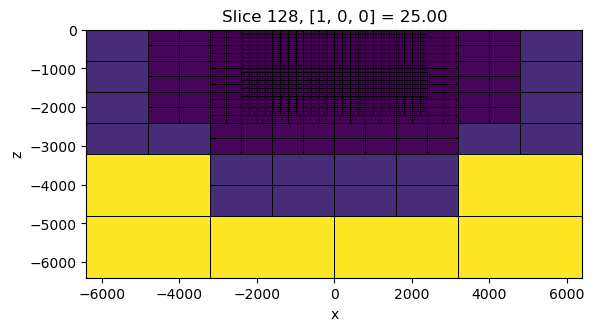

In [3]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes, normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.show()

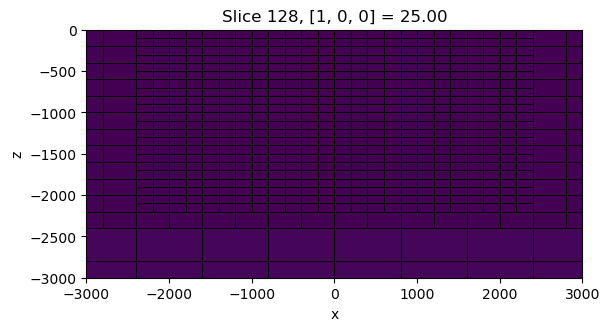

In [4]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes, normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.xlim(-3e3, 3e3)
plt.ylim(-3e3, 0)
plt.show()

In [5]:
block = (-300, 300, -300, 300, -800, -500)

model = np.zeros(mesh.n_cells)
model = simpeg.utils.model_builder.add_block(
    mesh.cell_centers,
    model,
    p0=np.array(block[::2]),
    p1=np.array(block[1::2]),
    prop_value=0.2,
)

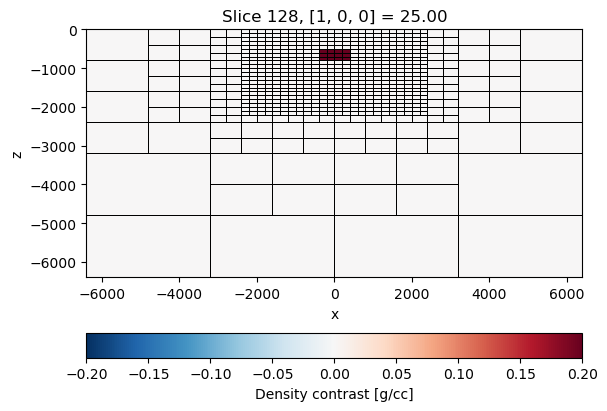

In [6]:
grid_opts = {"linewidth": 0.5, "color": "k"}

maxabs = np.max(np.abs(model))
                
tmp, = mesh.plot_slice(
    model,
    normal="x",
    grid=True,
    grid_opts=grid_opts,
    clim=(-maxabs, maxabs),
    pcolor_opts=dict(cmap="RdBu_r"),
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, orientation="horizontal", label="Density contrast [g/cc]")
plt.show()

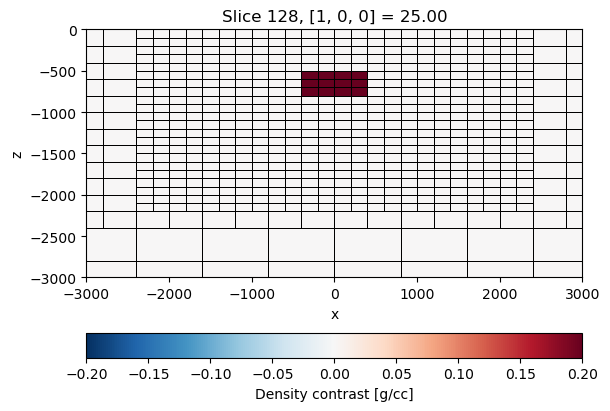

In [7]:
grid_opts = {"linewidth": 0.5, "color": "k"}

maxabs = np.max(np.abs(model))
                
tmp, = mesh.plot_slice(
    model,
    normal="x",
    grid=True,
    grid_opts=grid_opts,
    clim=(-maxabs, maxabs),
    pcolor_opts=dict(cmap="RdBu_r"),
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, orientation="horizontal", label="Density contrast [g/cc]")
plt.xlim(-3e3, 3e3)
plt.ylim(-3e3, 0)
plt.show()

## Forward modelling

In [8]:
region = (-2e3, 2e3, -2e3, 2e3)
shape = (51, 51)
height = 10.0

easting = np.linspace(*region[:2], shape[1])
northing = np.linspace(*region[2:], shape[0])
easting, northing = np.meshgrid(easting, northing)
upward = height * np.ones_like(easting)

receiver_locations = np.vstack(
    tuple(c.ravel() for c in (easting, northing, upward))
).T
receiver_locations.shape

(2601, 3)

In [9]:
receivers = potential_fields.gravity.Point(
    receiver_locations,
    components="gz",
)

source = potential_fields.gravity.SourceField(
    receiver_list=[receivers],
)

survey = potential_fields.gravity.Survey(source)

In [10]:
mapping = simpeg.maps.IdentityMap(mesh)
simulation = potential_fields.gravity.Simulation3DIntegral(
    mesh=mesh,
    survey=survey,
    rhoMap=mapping,
    engine="choclo",
)

In [11]:
gz = simulation.dpred(model)
gz

array([-0.00706398, -0.00748313, -0.00792556, ..., -0.00792556,
       -0.00748313, -0.00706398], dtype=float32)

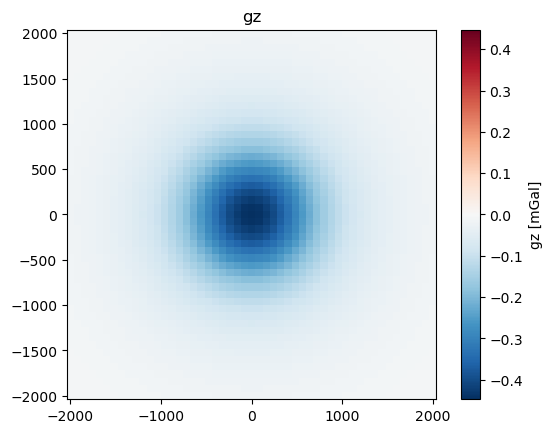

In [12]:
maxabs = np.max(np.abs(gz))

plt.pcolormesh(
    easting,
    northing,
    gz.reshape(easting.shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz [mGal]")
plt.title("gz")
plt.show()

Add gaussian noise to the synthetic data

In [13]:
percentage = 1/100
rng = np.random.default_rng(42)

std = percentage * np.max(np.abs(gz))
gz += rng.normal(loc=0, scale=std, size=gz.size)

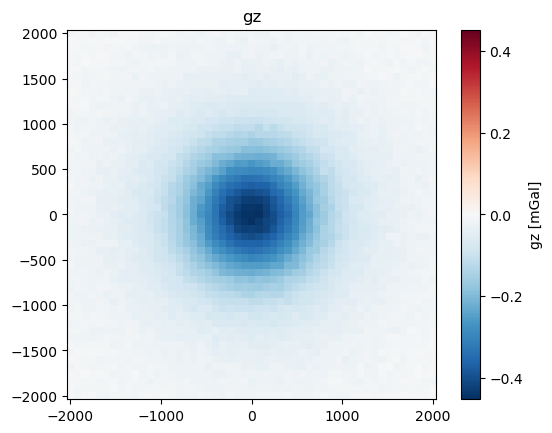

In [14]:
maxabs = np.max(np.abs(gz))

plt.pcolormesh(
    easting,
    northing,
    gz.reshape(easting.shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz [mGal]")
plt.title("gz")
plt.show()

## Save data in file

In [15]:
easting, northing, upward = tuple(
    receivers.locations[:, i] for i in range(3)
)
gz_std = np.ones_like(gz) * std

df = pd.DataFrame(
    dict(
        easting=easting,
        northing=northing,
        upward=upward,
        gz=gz,
        gz_std=gz_std,
    )
)
df

,easting,northing,upward,gz,gz_std
0,-2000.0,-2000.0,10.0,-0.005701,0.004473
1,-1920.0,-2000.0,10.0,-0.012135,0.004473
2,-1840.0,-2000.0,10.0,-0.004569,0.004473
3,-1760.0,-2000.0,10.0,-0.004184,0.004473
4,-1680.0,-2000.0,10.0,-0.017608,0.004473
...,...,...,...,...,...
2596,1680.0,2000.0,10.0,-0.003344,0.004473
2597,1760.0,2000.0,10.0,-0.007108,0.004473
2598,1840.0,2000.0,10.0,-0.016486,0.004473
2599,1920.0,2000.0,10.0,-0.002839,0.004473


In [20]:
df.to_csv("gravity.csv", index=None)

In [17]:
region = (-2e3, 2e3, -2e3, 2e3)

In [18]:
spacing = (10, 10, 5)

In [19]:
padding = 80
region_pad = vd.pad_region(region, padding)
region_pad

NameError: name 'vd' is not defined

In [ ]:
mesh_bottom, mesh_top = -150, 0
boundaries = list(region_pad) + [mesh_bottom, mesh_top]

In [ ]:
def get_box_region(mesh, padding_added):
    """
    Return the region for applying refinement on the mesh
    """
    # Get true boundaries of the mesh
    west, south = mesh.origin[:2]
    east = west + mesh.hx[0] * mesh.hx.size
    north = south + mesh.hy[0] * mesh.hy.size
    # Remove the padding added to the region
    return (west + padding, east - padding, south + padding, north - padding)

In [ ]:
mesh = create_treemesh(boundaries, spacing, adjust="region")

# Refine mesh
lower_left = [region[0], region[2], -80]
upper_right = [region[1], region[3], mesh_top]
mesh.refine_box(
    lower_left,
    upper_right,
    levels=7,
    finalize=False,
)

mesh.finalize()
mesh

In [ ]:
grid_opts = {"linewidth": 0.5, "color": "k"}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
ax.set_aspect("equal")
tmp, = mesh.plot_slice(
    mesh.cell_volumes,
    ax=ax,
    normal="y",
    grid=True,
    grid_opts=grid_opts,
)
plt.show()